<a href="https://colab.research.google.com/github/vicmancr/bigdataschool/blob/main/Generalisable_cardiac_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1. Download data

Download dataset into the `./data` folder.


In [1]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
gdown 4.6.0 at /usr/local/lib/python3.8/dist-packages


In [2]:
# Download the dataset
!gdown "1UojNr21N02bRXuOi2vOBlQ9z0X7OSJ0p"

Downloading...
From: https://drive.google.com/uc?id=1UojNr21N02bRXuOi2vOBlQ9z0X7OSJ0p
To: /content/mnms_bigdataschool.tar.xz
100% 121M/121M [00:02<00:00, 54.9MB/s]


In [3]:
import tarfile
# Unzip the '.tar.xz' file to the current directory
datafile = tarfile.open('mnms_bigdataschool.tar.xz')
datafile.extractall(path='./data')
datafile.close()


# Step 2. Load and visualize data

## Know your data

In this section we are going to learn how to load medical datasets and how to visualize the images contained on these datasets.

In [5]:
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import cv2

## Load an example

In [ ]:
nii_file = nib.load('./data/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED.nii.gz')
image = nii_file.get_fdata()
type(image), image.shape

(numpy.ndarray, (216, 256, 13))

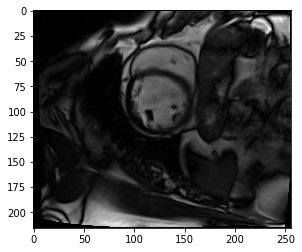

In [ ]:
# Let's plot the 5th component from the last axis
# (that is, the array of shape (216,256) in fifth position in the last axis)
plt.imshow(image[...,5], cmap='gray')

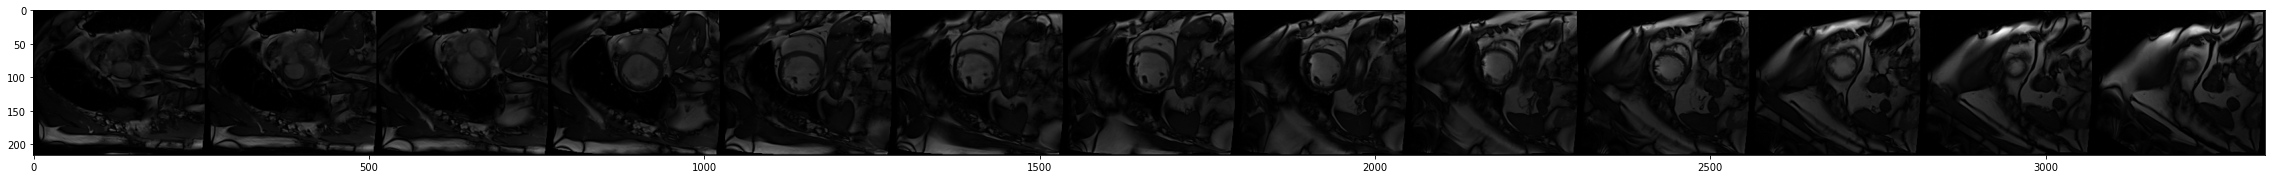

In [ ]:
# Let's plot now all the components separately (note that the last component is the heart axis)
plt.figure(figsize=(40,16))
plt.imshow(
    np.hstack([*np.moveaxis(image,2,0)]), cmap='gray')
plt.show()


## What about the delineation?

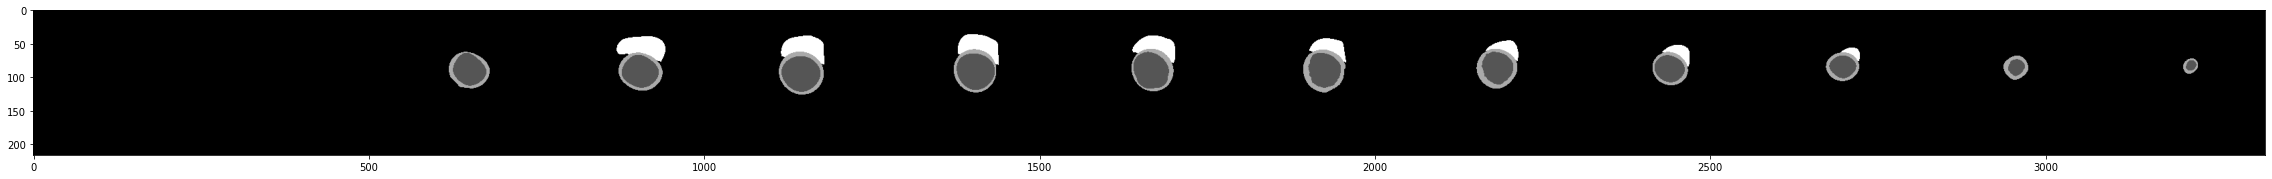

In [ ]:
nii_file = nib.load('./data/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED_gt.nii.gz')
delin = nii_file.get_fdata()
# Let's plot all the components separately as well
plt.figure(figsize=(40,16))
plt.imshow(
    np.hstack([*np.moveaxis(delin,2,0)]), cmap='gray')
plt.show()


## Let's combine both
We can crop the delineated part, for example:

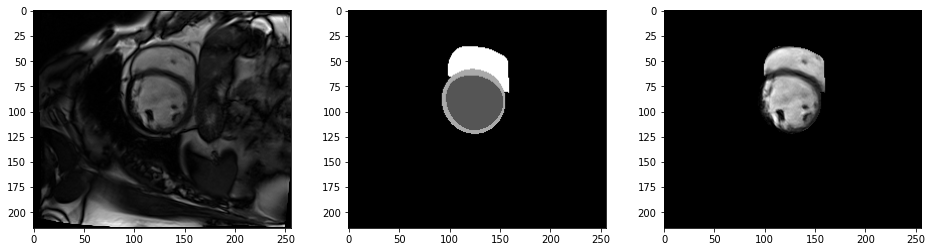

In [ ]:
z = 5 # Choose the 5th component again, as an example

f, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].imshow(image[...,z], cmap='gray')
axs[1].imshow(delin[...,z], cmap='gray')
axs[2].imshow(image[...,z] * np.clip(delin[...,z], 0, 1), cmap='gray')

plt.show()

or plot the delineation over the image:

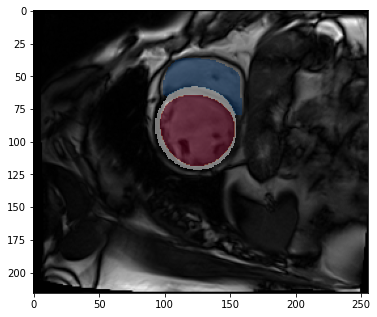

In [ ]:
z = 5

plt.figure(figsize=(6,6))
plt.imshow(image[...,z], cmap='gray')
masked = np.ma.masked_where((delin[...,z] == 0), delin[...,z])
plt.imshow(masked, cmap='RdBu', alpha=0.5)

plt.show()

## Images in PNG format

In order to work more easily, we converted the files to PNG format from Nifti. You can check that they can be visualized in a similar manner.


Note that image intensities are now in the range [0, 255] while the mask values are integers {0,1,2,3}.

We rescale them in the plot for better contrast. You can try to plot without rescaling to see what happens. **Why do you think the image looks different if you do so?**

In [ ]:
def rescale(im, _min=0, _max=1):
    '''
    Rescale the input image intensities to a given range [_min, _max]
    '''
    assert _max > 0, 'Max value must be greater than 0.'
    assert type(im) == np.ndarray, 'Pass image as a numpy array.'

    return _max * (im - im.min() + _min) / (im.max() - im.min())

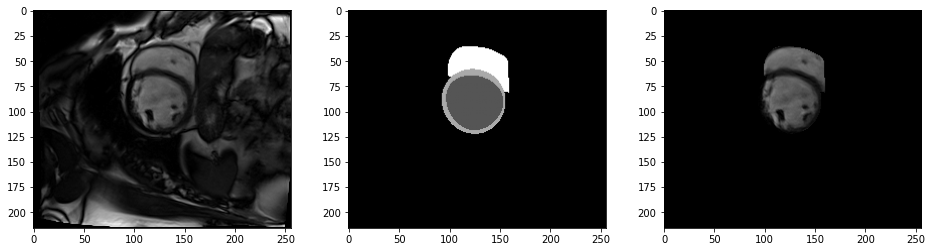

In [ ]:
image = cv2.imread('./data/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z05.png')
delin = cv2.imread('./data/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z05_gt.png')
image = rescale(image)
f, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rescale(delin), cmap='gray')
axs[2].imshow(image * np.clip(delin, 0, 1), cmap='gray')

plt.show()

# Step 3. Build your model

In this section we will design the model architecture that will be used for the segmentation task (for predicting the segmentations that we saw in the `Dataset` notebook).

We start by building the simple and successful U-Net model by [Ronneberger, Fisher and Brox (2015)](https://doi.org/10.1007/978-3-319-24574-4_28):

<img src="https://drive.google.com/uc?id=1Kuu5hPwxV2lUAgq_cXG0rDwTKFiJYPjF" alt="UNet architecture from Ronneberger, Figher and Brox paper." width="700"/>

This code is based on https://github.com/milesial/Pytorch-UNet.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Model structure

In pytorch, the models have the following `class` structure, with a initialization or constructor function and a `forward` that is called everytime the model is called:

In [ ]:
class UNetSample(nn.Module):
    def __init__(self):
        'Define the LAYERS of network'
        super().__init__()
        self.layer1 = nn.Identity()
        self.layer2 = nn.Identity()
        
        self.outlayer = nn.Identity()

    def forward(self, input_image):
        'Specify how data is TRANSFORMED through the network'
        x1 = self.layer1(input_image)
        x2 = self.layer2(x1)
        logits = self.outlayer(x2)

        return logits

We work with these models by instantiating them first

In [ ]:
model = UNetSample()

and calling them on input data (images). An image is passed as input and transformed to a new image (identity transformation for this case):

In [ ]:
image = torch.ones((5,5))
model(image)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

## Let's build a real U-Net

We need the building blocks first. So let's build them in a clean and modular way.

First, we need the **basic building block**, which is a composition of a convolutional operation, a normalization layer and an activation function (x2):

<img src='https://drive.google.com/uc?id=1nzV0ympWvF-V3ExEDvgL8q1ksW_AK5oO' alt="Basic convolutional blocks" width="500"/>

Notice the use of dynamical variables for the `output_channels` to implement blocks with varying number of channels (64, 128, 256, 512).

In [ ]:
class DoubleConv(nn.Module):
    '''
    |------|    |------|    |------|    |------|    |------|    |------|
    | Conv | => | [BN] | => | ReLU | => | Conv | => | [BN] | => | ReLU |
    |------|    |------|    |------|    |------|    |------|    |------|
    '''
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # One
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Two
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

And then we can compose it with the **downsampling block**

<img src='https://drive.google.com/uc?id=12GkrIhoAXLACUi8wKWPVkjVpviuGeGbk' alt='Downsampling block' width='150'/>


In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            # Use the previous block
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

and the **upsampling block**

<img src='https://drive.google.com/uc?id=1rwO-LHo5XJsH9KWEWvGX2VRXx04xoubv' alt='Upsampling block' width='150'/>

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Notice the two inputs:
        # - x1 (the data from the previous block, goes through the green arrow)
        # - x2 (the data from the equivalent layer of the encoding path, goes through the gray arrow)
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Fix size issues to match dimensions of x1 and x2 arrays
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate both arrays
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

The **last layer** is simply a 1x1 convolution (light blue color in the figure above) so we create another class for it as well:

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

Now we can put the pieces together to create **our first model**

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoding leg
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        # Decoding leg
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
model = UNet(1,3)

In [ ]:
image = torch.ones((1,1,256,256))
output = model(image)
output.shape

torch.Size([1, 3, 256, 256])

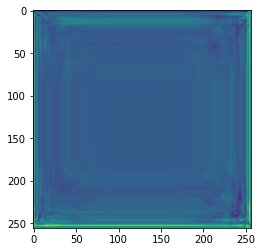

In [ ]:
plt.imshow(output[0,0].detach().numpy())

# Step 4. Train your model

Now we are ready to train a deep learning model. For the training we need to consider the selection of adequate **data augmentation**, one or a combination of several **loss functions** and an **optimizer**.

In [ ]:
import glob
import torch
from skimage.transform import resize 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

## Loss function

The function that the network is minimizing. It must be related to the objective and lower values mean better performance.

One very commonly used loss is the **Cross-Entropy (CE) loss**:
\begin{equation}
    CE(p,q) = - \sum_{x\in\mathcal{X}} p(x) \log q(x)
\end{equation}
for $p$ and $q$ probability distributions with support $\mathcal{X}$.

### What is the translation to the discrete network outputs?

\begin{equation}
    \ell_{CE}(y,\hat{y}) = - \sum_{i=1}^{\text{output size}} y_i \log\left(\hat{y}_i\right)
\end{equation}
where $y$ is the groundtruth vector (as one-hot encoding) and $\hat{y}$ represents the prediction probabilities. 

This sum is greater than zero if the positives ($y_j=1$) have probabilities below 1 ($\hat{y}_j < 1 \Rightarrow \log(\hat{y}_j) < 0$). The sum reaches its minimum (zero) when all positives have a prediction probability of 1.

[You can convince yourself by carefully analyzing the expression for $\ell_{CE}$ and by checking the implementation in [pytorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).]

The CE loss only focuses on the positives, but its variant, the **Binary Cross-Entropy** also considers the negatives in the sum:
\begin{equation}
    \ell_{BCE}(y,\hat{y}) = - \sum_{i=1}^{\text{output size}} \left( y_i \log\left(\hat{y}_i\right) + (1-y_i) \log\left(1-\hat{y}_i\right) \right)
\end{equation}

Other losses can be considered. See the recent publication by [Du et al. 2022](https://doi.org/10.1109/JBHI.2022.3222390) where the authors present a nice comparison between losses for medical image segmentation, in case you are interested in knowing more. Or this work by [Ma et al. 2021](https://www.sciencedirect.com/science/article/pii/S1361841521000815):

<img src="https://drive.google.com/uc?id=1zajXDhESbTzCfcuOsHwoC9Be6DwRY28D" alt="Classification of loss functions used in image segmentation" width="600"/>

[Source: https://github.com/JunMa11/SegLoss]

For this run we'll use the **Binary Cross-Entropy**, but you can experiment with other losses and combinations of them.

In [ ]:
loss_fn = nn.BCELoss()

## Optimizers

The algorithm that updates the weights of the network based on the loss function.

There are plenty of algorithms and variations, but we will use the basic one: **Stochastic Gradient Descent (SGD)**.

In [ ]:
model = UNet(n_channels=1, n_classes=4)
# We need to provide the weights of the model we are training
optimizer = optim.SGD(model.parameters(), lr=1e-3)

## Data augmentation

The variations introduced to the training data to increase its diversity in position, location, appearance, etc. This step has shown to be key for generalization, even to images that were acquired with machines from different manufacturers ([Campello et al. 2021](https://doi.org/10.1109/TMI.2021.3090082)).

Some examples of the variations performed to images:

<img src="https://drive.google.com/uc?id=1Rs0kGw9vPCAg8rZqNj-Jy01wSEddm4wd" alt="Example of images obtained after the application of different shape and intensity transformations" width="600"/>

[Source: Campello et al. 2021]

To implement the different data augmentation we'll use [`monai`](https://monai.io/), a python-based framework for deep learning in healthcare imaging.

It has many functions that will save us time.

In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.6 MB/s eta 0:00:00


In [ ]:
from monai.data import Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Resized, RandRotated, \
    ScaleIntensityd, EnsureTyped, RandBiasFieldd, RandAdjustContrastd, \
    AsDiscreted, ToTensord, Rand2DElasticd

In monai, we specify the augmentation techniques as a list of transformations. We'll consider some of the augmentations listed above: bias field modification, contrast adjustment, elastic deformations and rotations.

In [ ]:
k = ["img", "seg"]
num_classes = 4
spatial_size = (256, 256)

seg_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    RandBiasFieldd(keys=["img"], prob=0.5),
    RandAdjustContrastd(keys=["img"], prob=0.5),
    Rand2DElasticd(
        keys=k, prob=1, spacing=[20,20],
        magnitude_range=(1,2), mode=["bilinear", "nearest"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    RandRotated(
        keys=k, prob=0.5, range_x=15,
        mode=['bilinear', 'nearest']
    ),
    Resized(keys=k, spatial_size=spatial_size),
    EnsureTyped(keys=k),
]

In [ ]:
image_filenames = list(sorted(glob.iglob('./data/mnms_png/training/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob('./data/mnms_png/training/*/*_sa_E?_z??_gt.png')))

transform = Compose(seg_transforms)
train_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

train_dset = Dataset(train_files_dict, transform=transform)
train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device='cuda'):
    size = len(dataloader.dataset)
    model.train()
    for bidx, batch in enumerate(dataloader):
        X, y = batch['img'], batch['seg']
        X, y = X.to(device).float(), y.to(device).float()

        # Compute prediction error
        pred = model(X)
        pred = F.softmax(pred, dim=1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if bidx % 100 == 0:
            loss, current = loss.item(), bidx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

model = UNet(1, num_classes).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dloader, model, loss_fn, optimizer, device)
print("Done!")

Device: cuda
Epoch 1
-------------------------------
loss: 0.630534  [    0/ 3284]
loss: 0.538979  [  400/ 3284]
loss: 0.467236  [  800/ 3284]
loss: 0.387476  [ 1200/ 3284]
loss: 0.323157  [ 1600/ 3284]
loss: 0.269361  [ 2000/ 3284]
loss: 0.258142  [ 2400/ 3284]
loss: 0.209153  [ 2800/ 3284]
loss: 0.177388  [ 3200/ 3284]
Epoch 2
-------------------------------
loss: 0.178036  [    0/ 3284]
loss: 0.143125  [  400/ 3284]
loss: 0.144189  [  800/ 3284]
loss: 0.131735  [ 1200/ 3284]
loss: 0.146903  [ 1600/ 3284]
loss: 0.137714  [ 2000/ 3284]
loss: 0.100894  [ 2400/ 3284]
loss: 0.121187  [ 2800/ 3284]
loss: 0.097494  [ 3200/ 3284]
Epoch 3
-------------------------------
loss: 0.079678  [    0/ 3284]
loss: 0.074637  [  400/ 3284]
loss: 0.075617  [  800/ 3284]
loss: 0.090090  [ 1200/ 3284]
loss: 0.091088  [ 1600/ 3284]
loss: 0.103109  [ 2000/ 3284]
loss: 0.113820  [ 2400/ 3284]
loss: 0.069886  [ 2800/ 3284]
loss: 0.110059  [ 3200/ 3284]
Epoch 4
-------------------------------
loss: 0.102493  [

One the training is finished, we can save the model to disk, so that we can recover it whenever we want.

In [ ]:
import os
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_3ep.pt')

Finally, we can check the predictions of the model on the testing (unseen) images.

In [ ]:
test_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    Resized(keys=k, spatial_size=spatial_size),
    EnsureTyped(keys=k),
]

In [ ]:
image_filenames = list(sorted(glob.iglob('./data/mnms_png/testing/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob('./data/mnms_png/testing/*/*_sa_E?_z??_gt.png')))

transform = Compose(test_transforms)
test_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

test_dset = Dataset(test_files_dict, transform=transform)
test_dloader = DataLoader(test_dset, batch_size=1, shuffle=False)

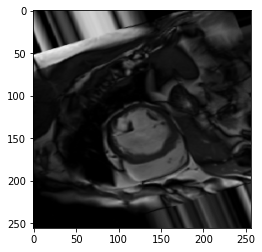

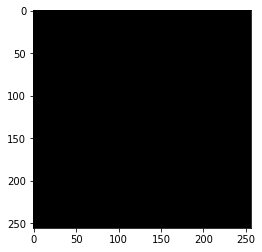

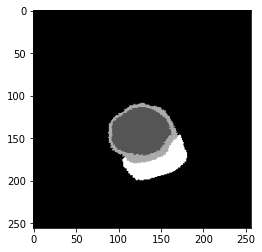

In [ ]:
batch = train_dset.__getitem__(4)
img, gt = batch['img'], batch['seg']
model.eval()
pred = model(img.to(device).unsqueeze(0))
plt.imshow(img[0].detach(), cmap='gray'); plt.show()
out = F.softmax(pred, dim=1).argmax(dim=1).squeeze()
plt.imshow(out.detach().cpu(), cmap='gray'); plt.show()
gt.shape
gt = gt.argmax(dim=0)
plt.imshow((gt-gt.min())/(gt.max()-gt.min()), cmap='gray'); plt.show()


# Step 5. It's hammer time


  A. Improve the model generalization by implementing additional data augmentation techniques. Check the [monai transforms](https://docs.monai.io/en/stable/transforms.html).

  B. Use a pre-trained model and freeze different different layers to find the best approach. You can use the [Pytorch Hub](https://pytorch.org/hub/) or [Huggingface](https://huggingface.co) to get your pre-trained model.

  C. Use a pre-trained model to analyze the performance in a new center with respect to the amount of samples used for fine-tuning the model. See point B for resources.

  D. Work on a test-time pipeline to improve the accuracy of a pre-trained model. You can start by implementing Test-time augmentations. Additionaly, you can estimate the uncertainty in the segmentation. See [Wang et al. 2018](https://openreview.net/pdf?id=Byxv9aioz).

  E. Train several models with images from one, two and three centers to compare the generalizability with respect to the variability in the training data. Does the generalization ability improve when including images from other centers?
  

In [6]:
info = pd.read_csv('./data/mnms_png/info.csv')

In [8]:
# There are 75, 50, 25 and 25 studies from centers 1,2,3 and 4 respectively 
info.groupby(['Centre', 'Vendor']).count()

,,External code,ED,ES
Centre,Vendor,,,
1,A,75,75,75
2,B,50,50,50
3,B,25,25,25
4,C,25,25,25


In [7]:
info.head()

,External code,Vendor,Centre,ED,ES
0,A0S9V9,A,1,0,9
1,A1D0Q7,B,2,0,9
2,A1D9Z7,A,1,22,11
3,A1E9Q1,A,1,0,9
4,A1O8Z3,B,3,23,10
